In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import datetime
import numpy as np
import pandas as pd
from pytz import utc
import matplotlib.pyplot as plt
import os

from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f

from dotenv import load_dotenv
load_dotenv()

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")

In [4]:
tracked_frequencies.columns

Index(['SS1', 'SS2', 'FA1', 'FA2'], dtype='object')

In [5]:
# Data Transformation
mode_simulation_data = {
    'SS1': pd.DataFrame(),
    'FA1': pd.DataFrame(),
    'SS2': pd.DataFrame(),
    'FA2': pd.DataFrame(),
}
for key in simulation_data.keys():
    if 'Eigen_' in key:
        simulation_data[key].rename(
            columns={
                '1st SS': 'SS1',
                '1st FA': 'FA1',
                '2nd SS': 'SS2',
                '2nd FA': 'FA2',
            }, inplace=True
        )
        for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
            mode_simulation_data[mode][key] = simulation_data[key][mode]

# order the columns
cols = list(simulation_data.keys())
ordered_cols = [cols[0]] + cols[9:11] + cols[1:9] + [cols[11]] + cols[20:22] + cols[12:20]
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    mode_simulation_data[mode] = mode_simulation_data[mode][ordered_cols]
    mode_simulation_data[mode].to_csv(simulations_data_path + "mode_frequencies/" + mode + ".csv")

tracked_modes = \
    tracked_frequencies.rename(
        columns = {
            'FA1': '1st FA',
            'FA2': '2nd FA',
            'SS1': '1st SS',
            'SS2': '2nd SS',
        }
    )

In [6]:
from oma_tracking.data import make_dataset

weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [7]:
from mlflow.tracking import MlflowClient
import mlflow
def get_model_run_id(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            return model_version_info.run_id
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

def get_model_flavor(model_name, stage):
    client = MlflowClient()
    for model_version_info in client.search_model_versions(f"name='{model_name}'"):
        if model_version_info.current_stage == stage:
            print(model_version_info)
            return model_version_info.flavors
    raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

def load_model_by_flavor(model_name, stage):
    """
    Load a model by its name and stage.
    Ensure that the model flavor is the original model flavor.
    (e.g. if the model was saved as a sklearn model,
    it should be loaded as a sklearn model)

    Args:
        model_name (_type_): _description_
        stage (_type_): _description_
    """
    run_id = get_model_run_id(model_name, stage)
    client = MlflowClient()
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.pyfunc.load_model(model_uri=model_uri)
    model_flavor = model.metadata.flavors
    print(model_flavor)
    if 'sklearn' in model_flavor:
        return mlflow.sklearn.load_model(model_uri=model_uri)
    elif 'xgboost' in model_flavor:
        return mlflow.xgboost.load_model(model_uri=model_uri)
    elif 'keras' in model_flavor:
        return mlflow.keras.load_model(model_uri=model_uri)
    elif 'pyfunc' in model_flavor:
        return mlflow.pyfunc.load_model(model_uri=model_uri)
    else:
        raise Exception(f"Could not find a model with name '{model_name}' in stage '{stage}'")

In [8]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!


mlflow experiment set to: NW2_scour


In [9]:
images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                "d01",
                "shap"
            ])

In [12]:
import mlflow
models = {}
rund_ids = {}
stage = 'Production'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    rund_ids[mode] = get_model_run_id(model_name, stage)
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print(stage + ' model ' + model_name + ' not sklearn' )
        try:
            models[mode] = \
                mlflow.xgboost.load_model(
                    model_uri=f"models:/{model_name}/{stage}")
        except:
            print(stage + ' model ' + model_name + ' not xgboost' )
            try:
                models[mode] = \
                    mlflow.pyfunc.load_model(
                        model_uri=f"models:/{model_name}/{stage}")
            except:
                print('no ' + stage + ' model ' + model_name)

Production model mpe_NW2_D01_SS1_normalization not sklearn


Trying to unpickle estimator DecisionTreeRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


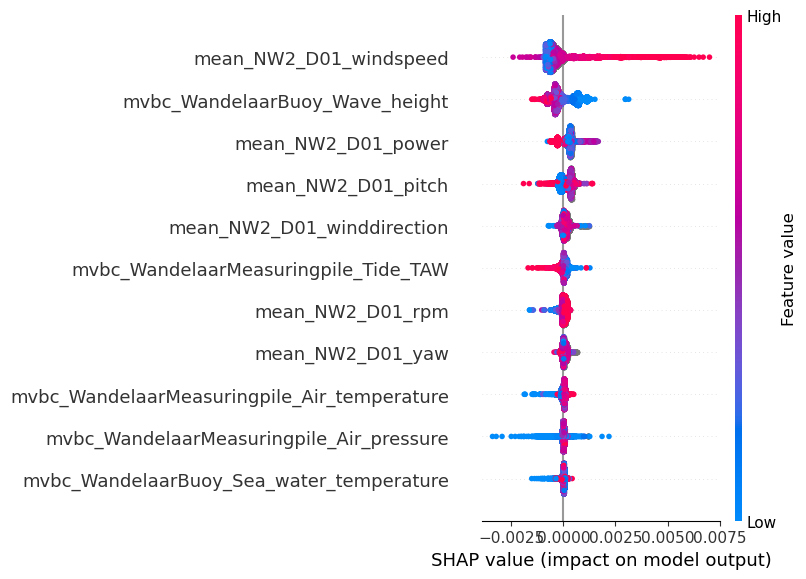

In [13]:
modes = ['SS1']
explainers = {}
shap_values = {}

for mode in modes:
    print(mode)
    model = models[mode]
    explainers[mode] = shap.Explainer(model)
    shap_values[mode] = explainers[mode](inputs)
    
    shap_summary_plot = shap.summary_plot(shap_values[mode], inputs)

In [14]:
inputs.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

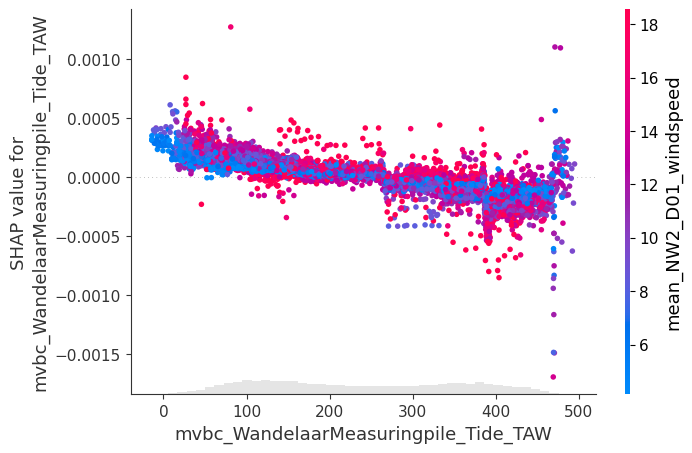

In [25]:
shap.plots.scatter(shap_values[mode][:,"mvbc_WandelaarMeasuringpile_Tide_TAW"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

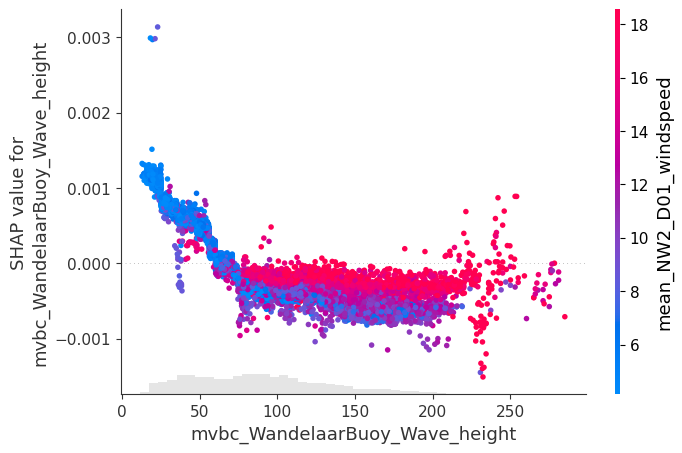

In [15]:
shap.plots.scatter(shap_values[mode][:,"mvbc_WandelaarBuoy_Wave_height"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

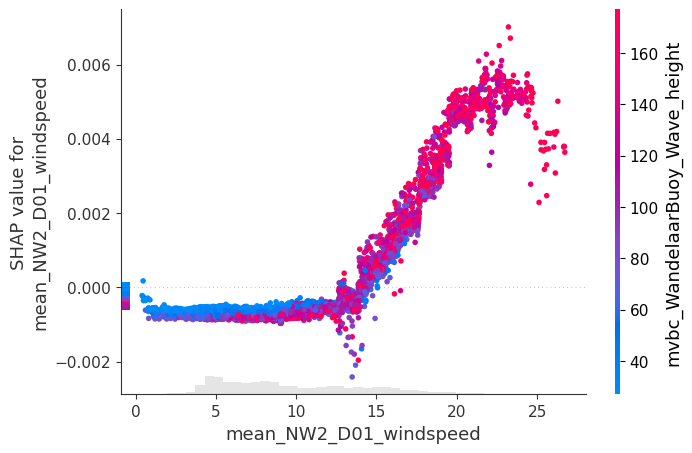

In [16]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mvbc_WandelaarBuoy_Wave_height"])

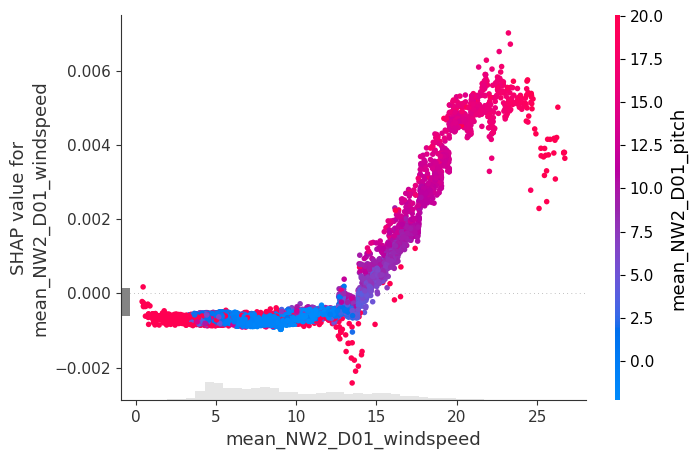

In [26]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_pitch"])

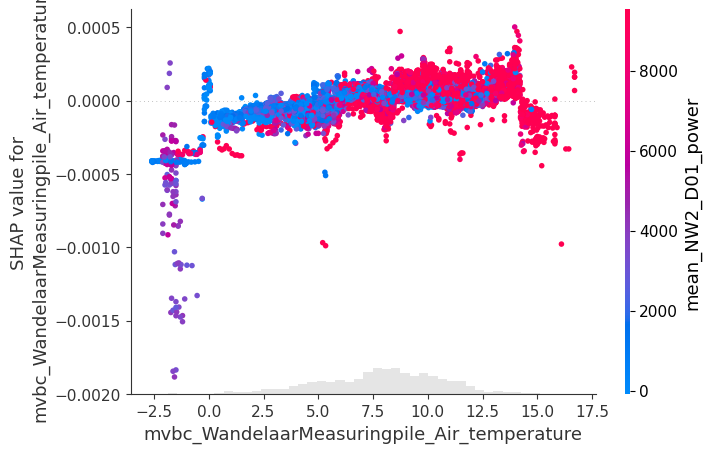

In [17]:
shap.plots.scatter(shap_values[mode][:,"mvbc_WandelaarMeasuringpile_Air_temperature"], color=shap_values[mode][:,"mean_NW2_D01_power"])

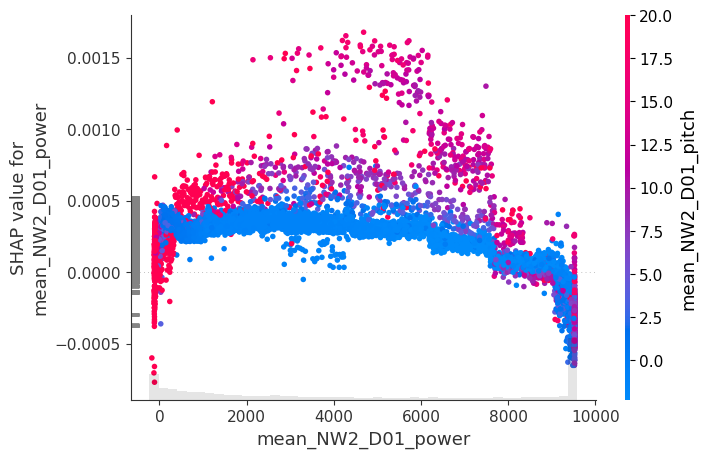

In [18]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_power"], color=shap_values[mode][:,"mean_NW2_D01_pitch"])

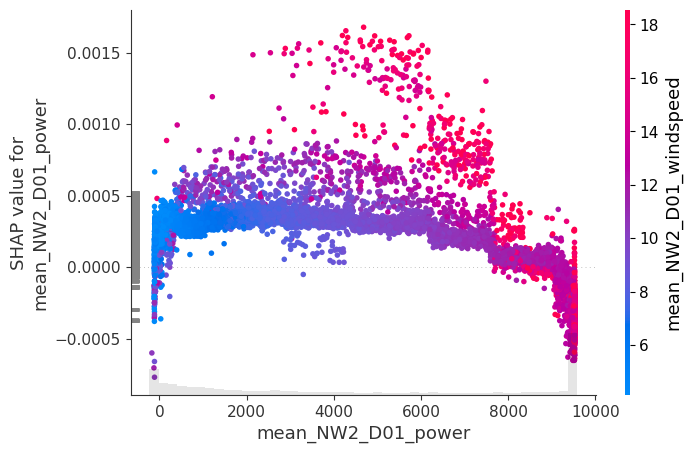

In [19]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_power"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

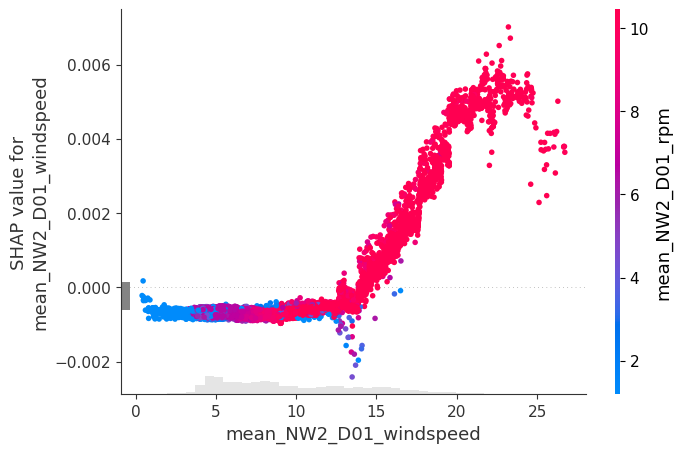

In [20]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_rpm"])

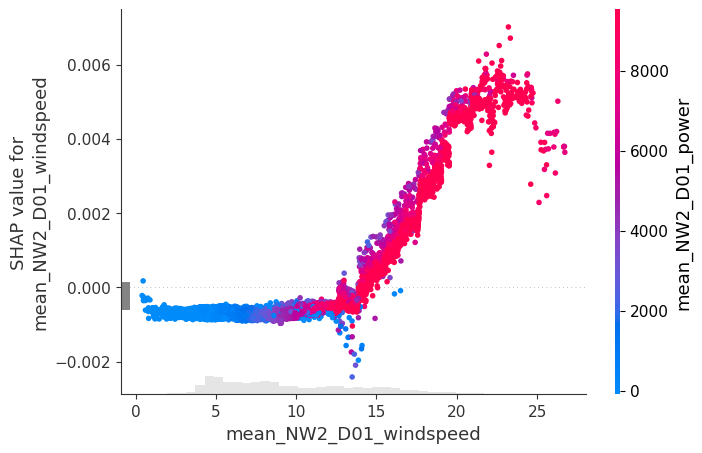

In [21]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_power"])

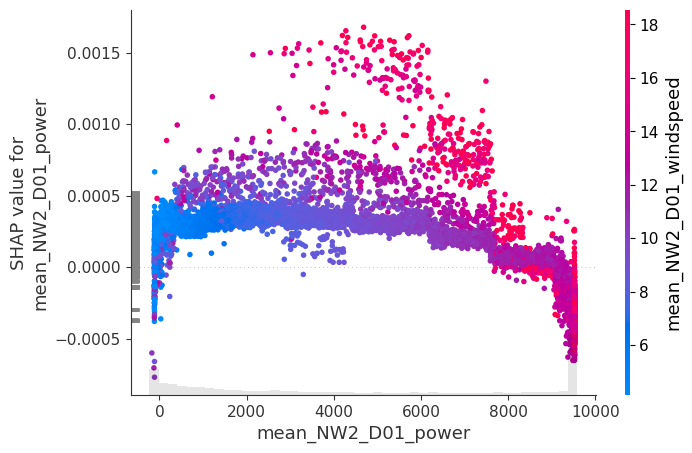

In [27]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_power"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

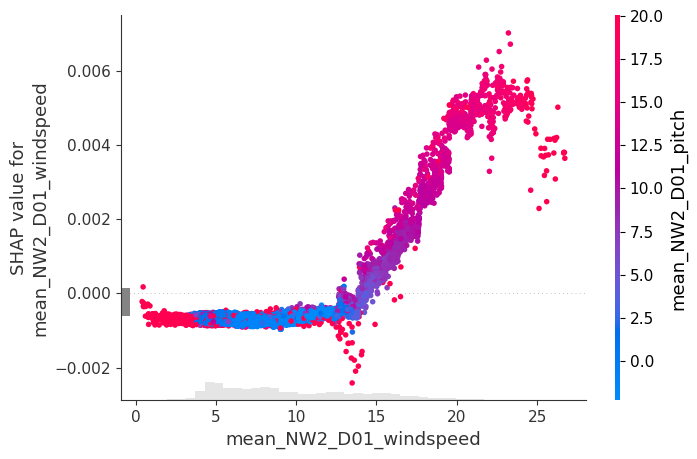

In [23]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_pitch"])

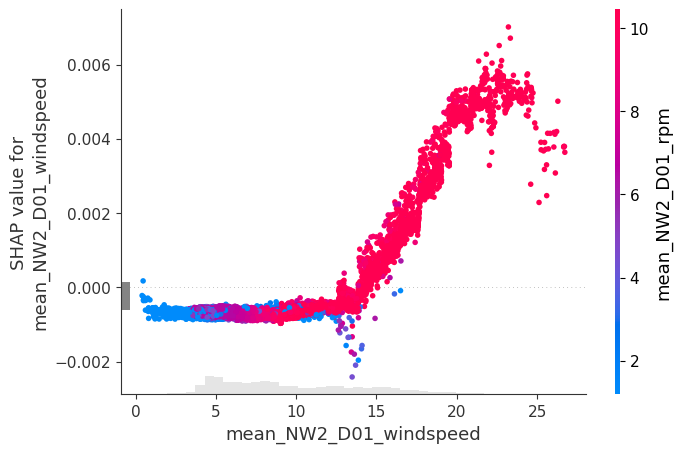

In [63]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_rpm"])

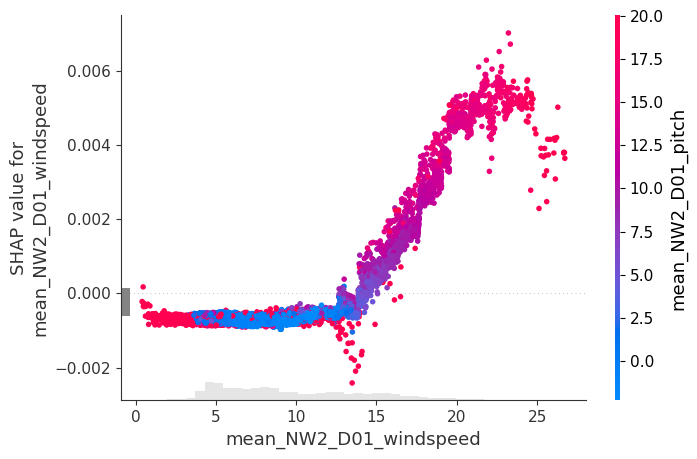

In [65]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_windspeed"], color=shap_values[mode][:,"mean_NW2_D01_pitch"])

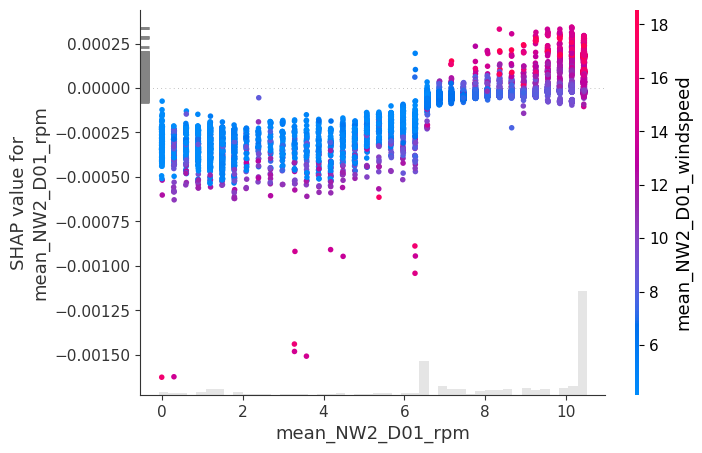

In [64]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_rpm"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

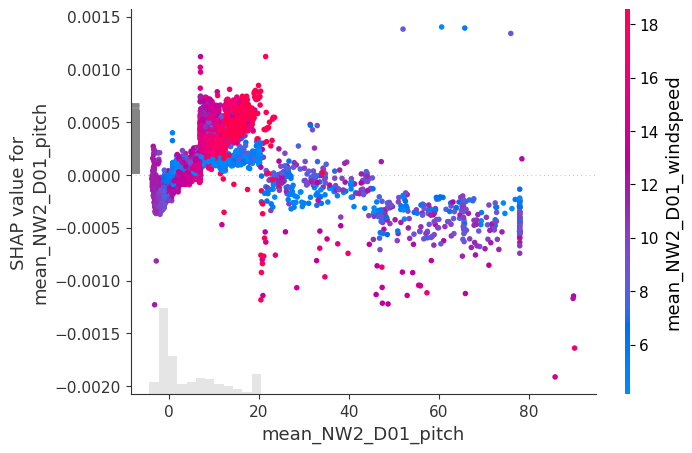

In [24]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_pitch"], color=shap_values[mode][:,"mean_NW2_D01_windspeed"])

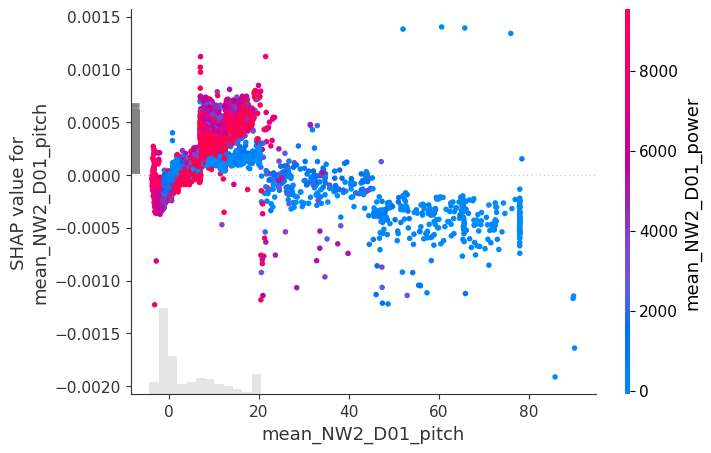

In [22]:
shap.plots.scatter(shap_values[mode][:,"mean_NW2_D01_pitch"], color=shap_values[mode][:,"mean_NW2_D01_power"])

In [67]:
tracked_frequencies[mode]

timestamp
2022-11-01 00:00:00+00:00    0.220005
2022-11-01 00:10:00+00:00    0.221963
2022-11-01 00:20:00+00:00    0.222790
2022-11-01 00:30:00+00:00    0.219814
2022-11-01 00:40:00+00:00    0.223240
                               ...   
2023-02-28 23:20:00+00:00    0.219556
2023-02-28 23:30:00+00:00    0.220365
2023-02-28 23:40:00+00:00    0.219310
2023-02-28 23:50:00+00:00    0.218162
2023-03-01 00:00:00+00:00    0.218791
Name: SS1, Length: 17281, dtype: float64

In [69]:
data_plot['mean_NW2_D01_windspeed'].loc[tracked_frequencies.index]

timestamp
2022-11-01 00:00:00+00:00    17.848
2022-11-01 00:10:00+00:00    17.773
2022-11-01 00:20:00+00:00    15.844
2022-11-01 00:30:00+00:00    16.023
2022-11-01 00:40:00+00:00    16.980
                              ...  
2023-02-28 23:20:00+00:00     6.555
2023-02-28 23:30:00+00:00     5.316
2023-02-28 23:40:00+00:00     5.762
2023-02-28 23:50:00+00:00     5.672
2023-03-01 00:00:00+00:00     5.648
Name: mean_NW2_D01_windspeed, Length: 17281, dtype: float64

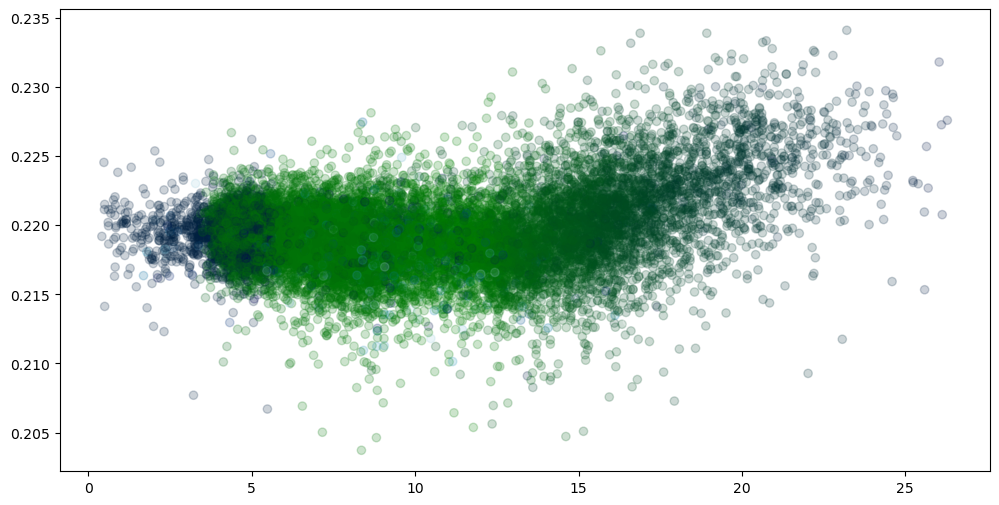

In [87]:
plt.figure(figsize=(12,6))
plt.scatter(data_plot['mean_NW2_D01_windspeed'].loc[tracked_frequencies.index], tracked_frequencies[mode], alpha=0.2, cmap = 'ocean', c=data_plot['mean_NW2_D01_pitch'].loc[tracked_frequencies.index])

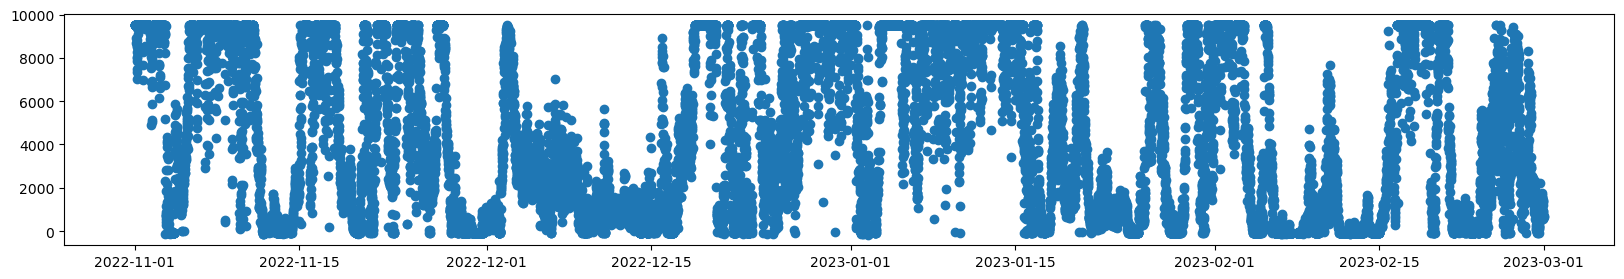

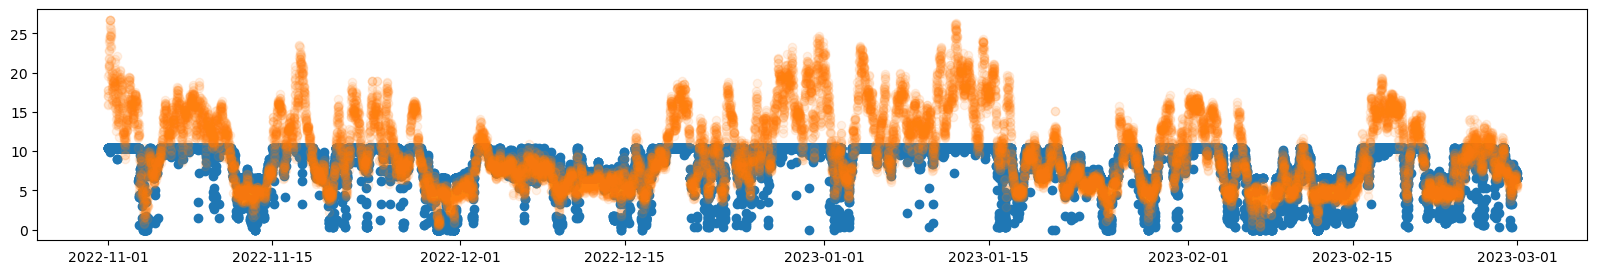

In [62]:
plt.figure(figsize=(20,3))
data_plot = inputs.iloc[]
plt.scatter(data_plot.index, data_plot['mean_NW2_D01_power'])
plt.show()
plt.figure(figsize=(20,3))
plt.scatter(data_plot.index, data_plot['mean_NW2_D01_rpm'])
plt.scatter(data_plot.index, data_plot['mean_NW2_D01_windspeed'], alpha=0.1)

In [36]:
shap.initjs()

shap.force_plot(explainers[mode].expected_value, shap_values[mode].values[0:1000,:], inputs.iloc[0:1000,:])

SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


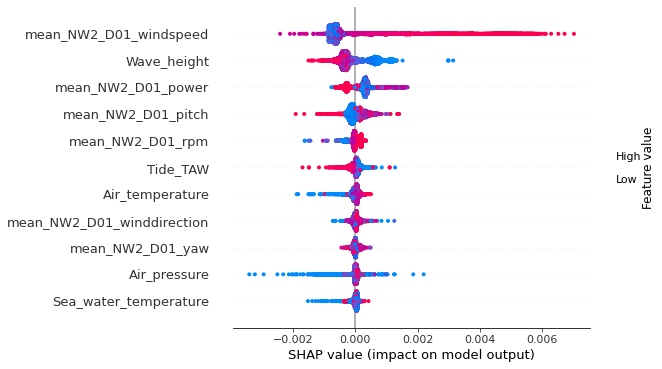

0bc02385673d4e1db6df576751993a65
figure_uploaded


<Figure size 432x288 with 0 Axes>

In [8]:
explainers = {}
shap_values = {}
images_path = \
    '/'.join(
        [
            "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
            "nw2",
            "d01",
            "shap"
        ])
for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]
    explainers[mode] = shap.Explainer(model)
    shap_values[mode] = explainers[mode](inputs)
    shap_summary_plot = shap.summary_plot(shap_values[mode], inputs)
    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    plt.savefig(fig_local_path)
    run_id = rund_ids[mode]
    print(run_id)
    with mlflow.start_run(run_id):
        mlflow.log_artifacts(
            fig_local_path,
            'figures')
    mlflow.end_run()
    print('figure_uploaded')

In [7]:
explainers = {}
shap_values = {}

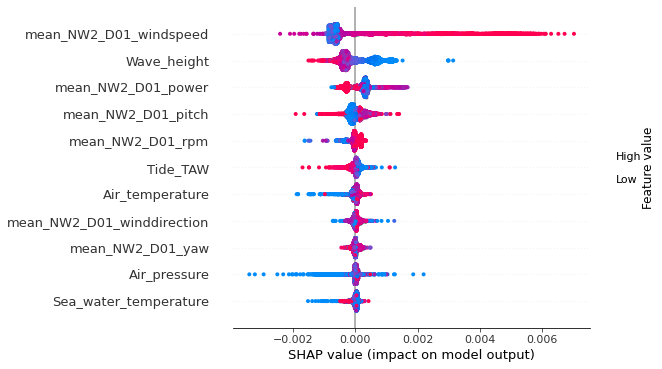

In [12]:
mode = 'SS1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap_summary_plot = shap.summary_plot(shap_values[mode], inputs)

In [20]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
import oma_tracking.models.mlflow_functions as mlflow_f

from dotenv import load_dotenv
load_dotenv()

True

In [21]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!


mlflow experiment set to: NW2_scour


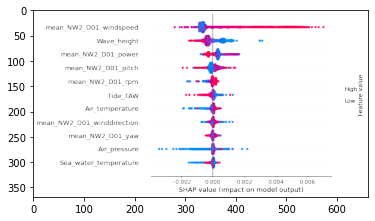

In [37]:
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

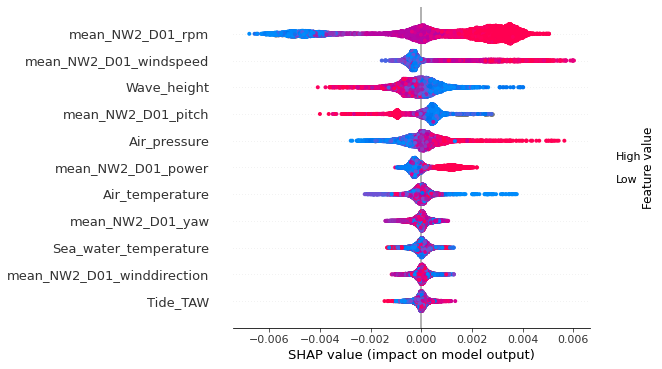

In [8]:
mode = 'FA1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

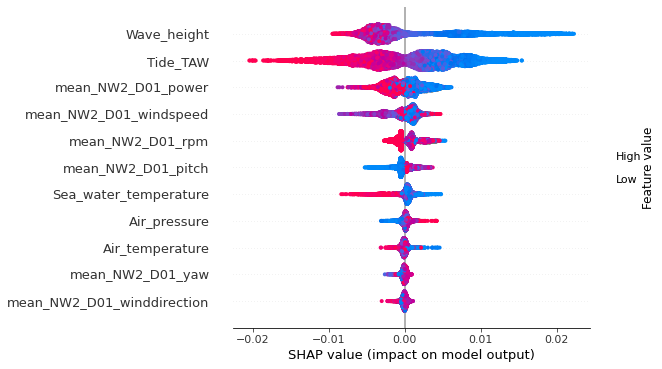

In [9]:
mode = 'SS2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

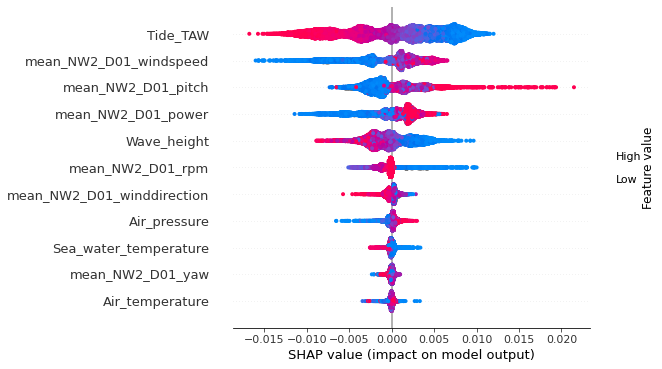

In [10]:
mode = 'FA2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

In [10]:
mode = 'SS1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

NameError: name 'models' is not defined

In [ ]:
import mlflow

stage = 'Production'
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                "d01",
                "shap"
            ])

    model = load_model_by_flavor(model_name, stage)
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(inputs)

    fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    shap.summary_plot(shap_value, inputs, show=False)

    plt.gcf().axes[-1].set_aspect('auto')
    plt.tight_layout()
    plt.gcf().axes[-1].set_box_aspect(50)
    fig = plt.gcf()
    fig.savefig(fig_local_path)
    plt.show()
    plt.close()

    run_id = get_model_run_id(model_name, stage)


    with mlflow.start_run(run_id):
        mlflow.log_artifact(
            fig_local_path,
            'figures'
        )
        mlflow.end_run()